In [111]:
%matplotlib inline 

import ipywidgets as widgets    
import numpy as np
from matplotlib import pyplot as plt
import cv2
from IPython.display import display


mode = cv2.IMREAD_COLOR
img = cv2.imread('original.png', mode)
#MODE: cv2.IMREAD_COLOR / cv2.IMREAD_GRAYSCALE


def _imgtype(image):
    if len(image.shape) == 3:
        return "RGB"
    elif len(image.shape) == 2:
        return "GRAY"
    else:
        return "Can't get the type of image"


def _drawLUT(lut, mode):
    t = np.arange(256)
    if _imgtype(img)=="RGB":
        # red dashes, blue squares and green triangles
        # plt.plot(t, lut[0:256], 'r--', t, lut[256:512], 'gs', t, lut[512:768], 'b^')
        plt.plot(t, lut[0:256], 'b--', t, lut[256:512], 'g--', t, lut[512:768], 'r--')
    elif _imgtype(img)=="GRAY":
        plt.plot(lut)
    plt.ylabel(('lut/' + mode))
    plt.show()


def _gethist(img, channel):
    size = img.shape[0]*img.shape[1]
    data = img.T.flatten()
    roi = data[channel*size:(channel+1)*size]
    return cv2.calcHist([roi],[0],None,[256],[0,256])


def _drawhist(img):
    if _imgtype(img)=="RGB":
        color = ('b','g','r')
        for channel,col in enumerate(color):
            histr = _gethist(img, channel)
            plt.plot(histr,color = col)
            plt.xlim([0,256])
        plt.title('Histogram for color scale picture')
        plt.show()
    elif _imgtype(img)=="GRAY":
        histogram, bins = np.histogram(img.flatten(),256,[0,256])
        width = 0.7 * (bins[1] - bins[0])
        center = (bins[:-1] + bins[1:])/ 2
        plt.bar(center, histogram, align='center', width=width)
        plt.show()


def _gethistogram(img):
    if _imgtype(image) in ("GRAY", "RGB"):
        if _imgtype(image) == "RGB":
            return cv2.calcHist([img], [0, 1, 2], None, [256], [0, 256])
        return cv2.calcHist([img], [0], None, [256], [0, 256])
    

def _lut(image, lut):
    if _imgtype(image) in ("GRAY", "RGB"):
        print("LUT")
        print(lut)
        t_lut = []
        if _imgtype(image) == "RGB":
            t_lut = np.dstack((lut[512:768], lut[256:512], lut[0:256] )) #bgr
        else:
            t_lut = lut
        dstImage = []
        dstImage = cv2.LUT(image, t_lut, np.asarray(dstImage))
        return dstImage.astype(np.uint8)
    else:
        raise IOError("not supported for this image mode")

        
def describe3d(image):
#     hist = cv2.calcHist([image], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
#     print(hist.flatten().shape)
    histogram = []
    if _imgtype(img)=="RGB":
        color = ('b','g','r')
        for channel,col in enumerate(color):
            histr = _gethist(img, channel)
            histogram.extend(histr)
    elif _imgtype(img)=="GRAY":
            histogram, bins = np.histogram(img.flatten(),256,[0,256])
    return np.asarray(histogram).ravel()


def autocontrast(image, cutofflo=0, cutoffhi=0):
    histogram = describe3d(image)
    lut = []
    for layer in range(0, len(histogram), 256):
        h = histogram[layer:layer+256]
        if cutofflo | cutoffhi: # == if cutoff != 0
            n = 0
            for ix in range(256):
                n = n + h[ix]
            # delete % of pixels from the low end
            if cutofflo:
                cut = n * cutofflo // 100
                for lo in range(256):
                    if cut > h[lo]:
                        cut = cut - h[lo]
                        h[lo] = 0
                    else:
                        h[lo] -= cut
                        cut = 0
                    if cut <= 0:
                        break
            # delete % of pixels from the high end
            if cutoffhi:
                cut = n * cutoffhi // 100
                for hi in range(255, -1, -1):
                    if cut > h[hi]:
                        cut = cut - h[hi]
                        h[hi] = 0
                    else:
                        h[hi] -= cut
                        cut = 0
                    if cut <= 0:
                        break
        # find current lowest/highest values
        for lo in range(256):
            if h[lo]:
                break
        for hi in range(255, -1, -1):
            if h[hi]:
                break
        print("Channel ", int(layer/256),  "; lower I-value = ", lo, "; high I-value = ", hi)
        if hi <= lo:
            lut.extend(list(range(256)))
        else:
            scale = 255.0 / (hi - lo)
            offset = -lo * scale
            for ix in range(256):
                ix = int(ix * scale + offset)
                if ix < 0:
                    ix = 0
                elif ix > 255:
                    ix = 255
                lut.append(ix)
    lut = np.asarray(lut)
    _drawLUT(lut, 'percent mode')
    dst = _lut(image, lut)
    return dst


def autocontrastByBorders(image, borders=[0,0]):
    histogram = describe3d(image)
    lut = []
    
    print("For each channel lower I-value = ", borders[0], "; High I-value = ", borders[1])
    for layer in range(0, len(histogram), 256):
        h = histogram[layer:layer+256]
        if borders[0] | borders[1]:
            # cut off pixels from both ends of the histogram
            # get number of pixels
            n = 0
            for ix in range(256):
                n = n + h[ix]
            if borders[0]:
                for lo in range(256):
                    if lo <= borders[0]:
                        h[lo] = 0
                    else:
                        break
            if borders[1] != 255:
                for hi in range(255, -1, -1):
                    if hi >= borders[1]:
                        h[hi]=0
                    else:
                        break

        lo = borders[0]
        hi = borders[1]
        
        if hi <= lo:
            lut.extend(list(range(256)))
        else:
            scale = 255.0 / (hi - lo)
            offset = -lo * scale
            for ix in range(256):
                ix = int(ix * scale + offset)
                if ix < 0:
                    ix = 0
                elif ix > 255:
                    ix = 255
                lut.append(ix)
    lut = np.asarray(lut)
    _drawLUT(lut, 'borders mode')
    dst = _lut(image, lut)
    return dst

In [112]:
borders = widgets.IntRangeSlider(
    value=[10, 200],
    min=0,
    max=255,
    step=1,
    description='Borders:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

display(borders)

percents = widgets.IntRangeSlider(
    value=[10, 90],
    min=0,
    max=100,
    step=1,
    description='Percents:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

display(percents)

A Jupyter Widget

A Jupyter Widget

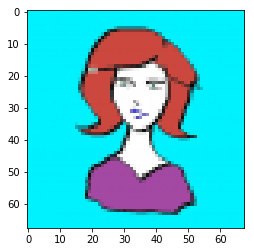

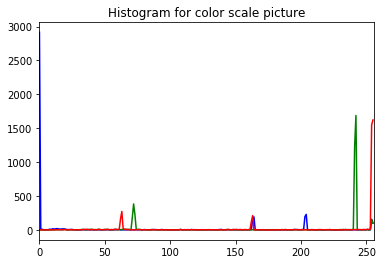

res_percentage
Channel  0 ; lower I-value =  0 ; high I-value =  204
Channel  1 ; lower I-value =  72 ; high I-value =  242
Channel  2 ; lower I-value =  63 ; high I-value =  255


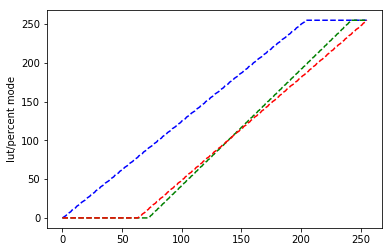

LUT
[  0   1   2   3   5   6   7   8  10  11  12  13  15  16  17  18  20  21
  22  23  25  26  27  28  30  31  32  33  35  36  37  38  40  41  42  43
  45  46  47  48  50  51  52  53  55  56  57  58  60  61  62  63  65  66
  67  68  70  71  72  73  75  76  77  78  80  81  82  83  85  86  87  88
  90  91  92  93  95  96  97  98 100 101 102 103 105 106 107 108 110 111
 112 113 115 116 117 118 120 121 122 123 125 126 127 128 130 131 132 133
 135 136 137 138 140 141 142 143 145 146 147 148 150 151 152 153 155 156
 157 158 160 161 162 163 165 166 167 168 170 171 172 173 175 176 177 178
 180 181 182 183 185 186 187 188 190 191 192 193 195 196 197 198 200 201
 202 203 205 206 207 208 210 211 212 213 215 216 217 218 220 221 222 223
 225 226 227 228 230 231 232 233 235 236 237 238 240 241 242 243 245 246
 247 248 250 251 252 253 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 25

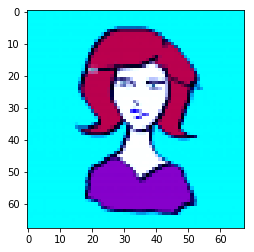

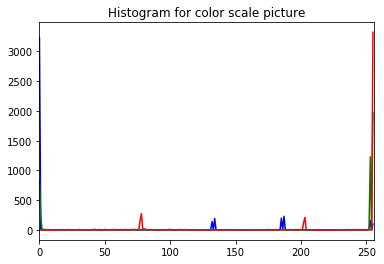

res_borders
For each channel lower I-value =  10 ; High I-value =  200


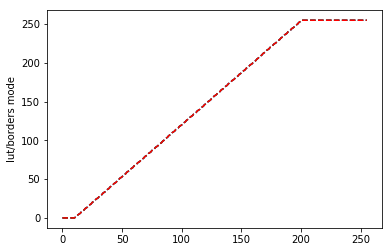

LUT
[  0   0   0   0   0   0   0   0   0   0   0   1   2   4   5   6   8   9
  10  12  13  14  16  17  18  20  21  22  24  25  26  28  29  30  32  33
  34  36  37  38  40  41  42  44  45  46  48  49  51  52  53  55  56  57
  59  60  61  63  64  65  67  68  69  71  72  73  75  76  77  79  80  81
  83  84  85  87  88  89  91  92  93  95  96  97  99 100 102 103 104 106
 107 108 110 111 112 114 115 116 118 119 120 122 123 124 126 127 128 130
 131 132 134 135 136 138 139 140 142 143 144 146 147 148 150 151 152 154
 155 157 158 159 161 162 163 165 166 167 169 170 171 173 174 175 177 178
 179 181 182 183 185 186 187 189 190 191 193 194 195 197 198 199 201 202
 203 205 206 208 209 210 212 213 214 216 217 218 220 221 222 224 225 226
 228 229 230 232 233 234 236 237 238 240 241 242 244 245 246 248 249 250
 252 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 25

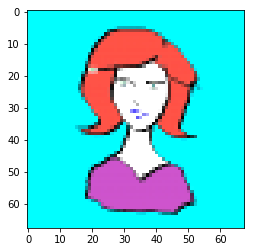

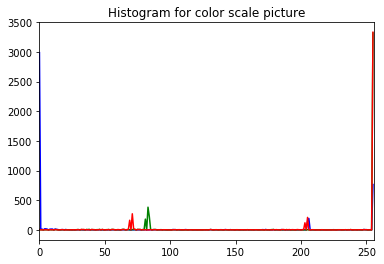

In [113]:
plt.imshow(img)
plt.show()
_drawhist(img)

# hist = cv2.calcHist([img], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])

print("res_percentage")
res_percentage = autocontrast(img, cutofflo=percents.value[0], cutoffhi=(100 - percents.value[1]))
plt.imshow(res_percentage)
plt.show()
_drawhist(res_percentage)
                              
print("res_borders")
res_borders = autocontrastByBorders(img, borders.value)
plt.imshow(res_borders)
plt.show()
_drawhist(res_borders)
